In [8]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

print('version of ipwidgets=',widgets.__version__)

from lib.Reconstruction_plots import *
from lib.decomposer import Eigen_decomp
from lib.YearPlotter import YearPlotter

import warnings
warnings.filterwarnings('ignore')
_figsize=[8,6]

Populating the interactive namespace from numpy and matplotlib
version of ipwidgets= 7.1.2


## High-dimensional vectors

We are used to work with 2 and 3 dimensional vectors, which we can think of as arrows in the plane or arrows in 3D space respectively.

* How can we visualize vectors that are in dimension higher than 3?

* One good way to visualize a $d$-dimensional vector is to draw it as a function from $1,2,\ldots,d$ to the reals.

* All of the vector operations are well defined, including approximating a function using an orthonormal set of functions.

To get an intuition about the working of the PCA, we used an example in the plane, or $R^2$.
While useful for intuition, this is not the typical case in which we use PCA. Typically we are interested in vectors in a space whose dimension is in the hundreds or more.

How can we depict such vectors? If the coordinates of the vector have a natural order. For example, if the coordinates correspond to a grid of times, then a good representation is to make a plot in which the $x$-axis is the time and the $y$-axis is the value that corresponds to this time. 

Later in this class we will consider vectors that correspond to the temperature at a particular location each day of the year. These vectors will be of length 365 (we omit the extra days of leap years) and the PCA analysis will reveal the low dimensional subspace.

### Function approximation
For now, we will consider the vectors that are defined by sinusoidal functions.

In [3]:
# We define a grid that extends from o to 2*pi
step=2*pi/365
x=arange(0,2*pi,step)
x

array([0.        , 0.01721421, 0.03442841, 0.05164262, 0.06885683,
       0.08607103, 0.10328524, 0.12049944, 0.13771365, 0.15492786,
       0.17214206, 0.18935627, 0.20657048, 0.22378468, 0.24099889,
       0.25821309, 0.2754273 , 0.29264151, 0.30985571, 0.32706992,
       0.34428413, 0.36149833, 0.37871254, 0.39592675, 0.41314095,
       0.43035516, 0.44756936, 0.46478357, 0.48199778, 0.49921198,
       0.51642619, 0.5336404 , 0.5508546 , 0.56806881, 0.58528301,
       0.60249722, 0.61971143, 0.63692563, 0.65413984, 0.67135405,
       0.68856825, 0.70578246, 0.72299667, 0.74021087, 0.75742508,
       0.77463928, 0.79185349, 0.8090677 , 0.8262819 , 0.84349611,
       0.86071032, 0.87792452, 0.89513873, 0.91235294, 0.92956714,
       0.94678135, 0.96399555, 0.98120976, 0.99842397, 1.01563817,
       1.03285238, 1.05006659, 1.06728079, 1.084495  , 1.1017092 ,
       1.11892341, 1.13613762, 1.15335182, 1.17056603, 1.18778024,
       1.20499444, 1.22220865, 1.23942286, 1.25663706, 1.27385

#### Define an orthonormal set

The dimension of the space is 365 (arbitrary choice: the number of days in a year).

We define some functions based on $\sin()$ and $\cos()$ 

In [6]:
c=sqrt(step/(pi))
v=[]
v.append(np.array(cos(0*x))*c/sqrt(2))
v.append(np.array(sin(x))*c)
v.append(np.array(cos(x))*c)
v.append(np.array(sin(2*x))*c)
v.append(np.array(cos(2*x))*c)
v.append(np.array(sin(3*x))*c)
v.append(np.array(cos(3*x))*c)
v.append(np.array(sin(4*x))*c)
v.append(np.array(cos(4*x))*c)

print("v contains %d vectors"%(len(v)))

v contains 9 vectors


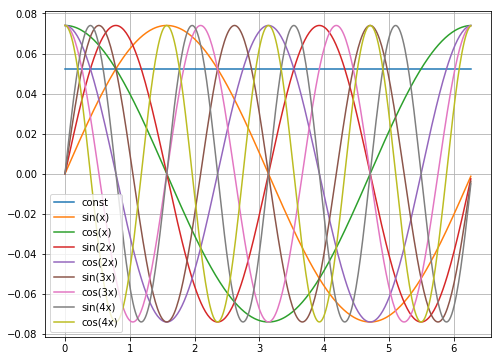

In [13]:
# plot some of the functions (plotting all of them results in a figure that is hard to read.
figure(figsize=_figsize)
for i in range(9):
    plot(x,v[i])
grid()
legend(['const','sin(x)','cos(x)','sin(2x)','cos(2x)','sin(3x)','cos(3x)','sin(4x)','cos(4x)']);

#### Check that it is  an orthonormal basis
This basis is not **complete** it does not span the space of all functions. It spans a 9 dimensional sub-space.

We will now check that this is an **orthonormal** basis. In other words, the length of each vector is 1 and every pair of vectors are orthogonal.

In [14]:
for i in range(len(v)): 
    print()
    for j in range(len(v)):
        a=dot(v[i],v[j])
        a=round(1000*a+0.1)/1000
        print('%1.0f'%a, end=' ')


1 0 0 0 0 0 0 0 0 
0 1 0 0 0 0 0 0 0 
0 0 1 0 0 0 0 0 0 
0 0 0 1 0 0 0 0 0 
0 0 0 0 1 0 0 0 0 
0 0 0 0 0 1 0 0 0 
0 0 0 0 0 0 1 0 0 
0 0 0 0 0 0 0 1 0 
0 0 0 0 0 0 0 0 1 

#### Rewriting the set of vectors as a matrix

Combining the vectors as rows in a matrix allows us use very succinct (and very fast) matrix multiplications instead of for loops with vector products.

In [17]:
U=vstack(v).transpose()
shape(U)

(365, 9)

### Approximating an arbitrary function
We now take an unrelated function $f=|x-4|$
and see how we can use the basis matrix `U` to approximate it. 

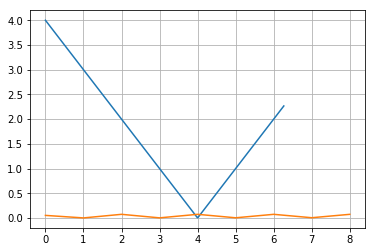

In [48]:

f1=abs(x-4)
plot(x,f1)
plot(U[1])

grid()



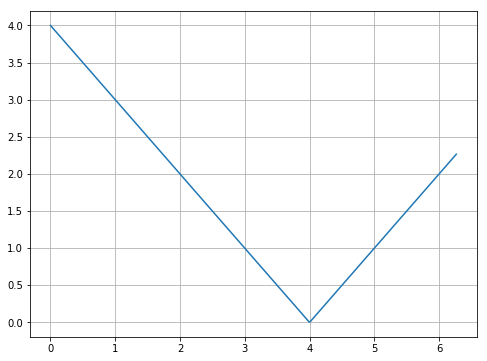

In [8]:
figure(figsize=_figsize)
plot(x,f1);
grid()

#### Approximations  of increasing accuracy
To understand how we can use a basis to approximate functions, we create a sequence of approximations $g(i)$ such that $g(i)$ is an approximation that uses the first $i$ vectors in the basis.

The larger $i$ is, the closer $g(i)$ is to $f$. Where the distance between $f$ and $g(i)$ is defined by the euclidean norm:
$$   \| g(i)- f \|_2
$$

#### Plotting the approximations
Below we show how increasing the number of vectors in the basis improves the approximation of $f$.

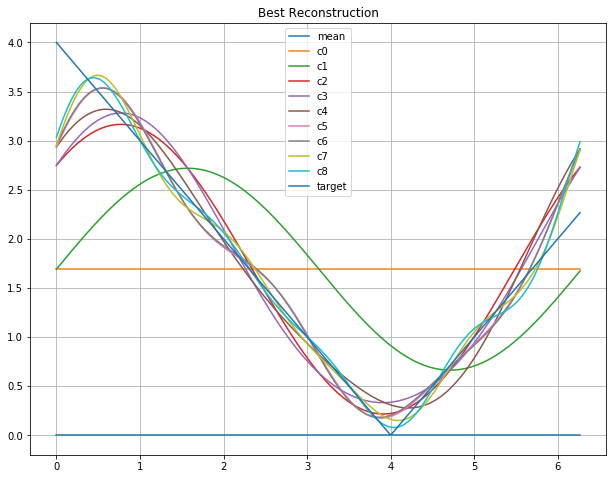

In [9]:
eigen_decomp=Eigen_decomp(x,f1,np.zeros(len(x)),U)
recon_plot(eigen_decomp,year_axis=False,Title='Best Reconstruction',interactive=False,figsize=_figsize);

In [10]:
eigen_decomp=Eigen_decomp(x,f1,np.zeros(len(x)),U)
plotter=recon_plot(eigen_decomp,year_axis=False,interactive=True,figsize=_figsize);
display(plotter.get_Interactive())

VBox(children=(HBox(children=(FloatSlider(value=0.0, description='c0', max=32.29570559348949, orientation='vertical', step=3.2295705593489488), FloatSlider(value=0.0, description='c1', max=13.890978134306339, orientation='vertical', step=1.389097813430634), FloatSlider(value=0.0, description='c2', max=14.285464698745864, orientation='vertical', step=1.4285464698745864), FloatSlider(value=0.0, description='c3', max=1.5637963122785787, orientation='vertical', step=0.15637963122785786), FloatSlider(value=0.0, description='c4', max=2.526640915803119, orientation='vertical', step=0.2526640915803119), FloatSlider(value=0.0, description='c5', max=2.972992156397289, orientation='vertical', step=0.2972992156397289), FloatSlider(value=0.0, description='c6', max=0.2130363937473089, orientation='vertical', step=0.02130363937473089), FloatSlider(value=0.0, description='c7', max=1.999629163316103, orientation='vertical', step=0.19996291633161029), FloatSlider(value=0.0, description='c8', max=1.1159489565455392, orientation='vertical', step=0.11159489565455391))), Output()))

#### Food for thought
Visually, it is clear that $g(i)$ is getting close to $f$ as $i$ increases. To quantify the improvement, compute 
$ \| g(i)- f \|_2 $ as a function of $i$

### Recovering from Noise

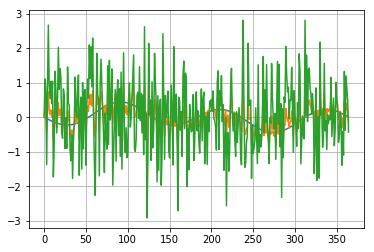

In [56]:
noise=np.random.normal(size=x.shape)
f1=2*v[1]-4*v[5]
f2=f1+0.3*noise

plot(f1)
plot(f2)
plot(noise)
grid()

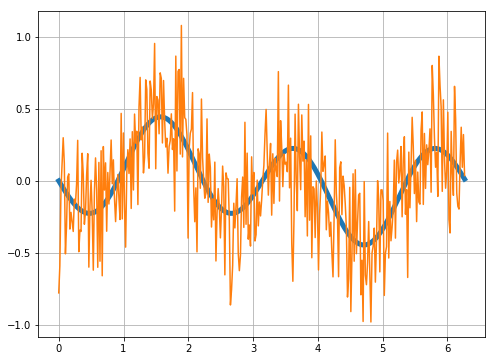

In [12]:
figure(figsize=_figsize)
plot(x,f1,linewidth=5);
plot(x,f2);
grid();

In [13]:
eigen_decomp=Eigen_decomp(x,f2,np.zeros(len(x)),U)
plotter=recon_plot(eigen_decomp,year_axis=False,interactive=True,figsize=_figsize);
display(plotter.get_Interactive())

VBox(children=(HBox(children=(FloatSlider(value=0.0, description='c0', max=0.0, min=-0.2818498071106761, orientation='vertical', step=0.02818498071106761), FloatSlider(value=0.0, description='c1', max=2.3032796280058996, orientation='vertical', step=0.23032796280058995), FloatSlider(value=0.0, description='c2', max=0.4360724678290948, orientation='vertical', step=0.04360724678290948), FloatSlider(value=0.0, description='c3', max=0.0, min=-0.363788772708446, orientation='vertical', step=0.0363788772708446), FloatSlider(value=0.0, description='c4', max=0.0, min=-0.2599667723795123, orientation='vertical', step=0.02599667723795123), FloatSlider(value=0.0, description='c5', max=0.0, min=-3.7601777337120836, orientation='vertical', step=0.37601777337120834), FloatSlider(value=0.0, description='c6', max=0.0008681296573809456, orientation='vertical', step=8.681296573809456e-05), FloatSlider(value=0.0, description='c7', max=0.10582738343612938, orientation='vertical', step=0.010582738343612938), FloatSlider(value=0.0, description='c8', max=0.16862807825411227, orientation='vertical', step=0.016862807825411226))), Output()))

## Summary
* Functions can be thought of as vectors and vice versa.
* The **fourier** basis is a set of orthonormal fuctions made of `sin`s and `cosine`s
* Orthonormal functions can be used to remove the noise added to an underlying distribution